### Import libraries

In [1]:
import sys
sys.path.append("..")
import os
from model import experimental_model, experimental2d_model, grapher
from data import batch_creator, loader
from helpers import helpers, plotter, metrics
import tensorflow as tf
import time
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# options: rbf, periodic
print('Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D')
kernel = input()
print('How many observations? (deafult 150000)')
dataset_size = input()
print('Do you want to overwrite data? True/False')
rewrite = input()
d = True if kernel.split('_')[-1] == '2D' else False
save_dir = os.path.expanduser('~/Downloads/GPT_' + kernel)

Kernel? rbf/rbf_noise/periodic/rbf_const_2D/rbf_rbf_2D
rbf_const_2D
How many observations? (deafult 150000)
1
Do you want to overwrite data? True/False
False


In [3]:
data = loader.load_data(kernel, size = dataset_size, rewrite = rewrite.capitalize(), diff_x= True, noise = False, d = d, ordered = True)

['em_te_2.npy', 'pad_pos_tr.npy', 'pad_pos_te.npy', 'em_te.npy', 'em_tr.npy', 'pad_y_fren_tr.npy', 'pad_y_fren_te.npy', 'em_tr_2.npy']


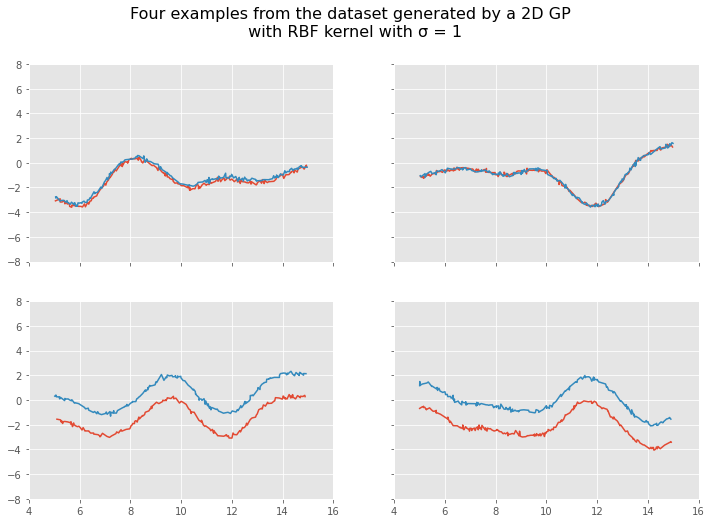

In [4]:
if d:
    plotter.plot_2d_examples(data[2], data[-2], data[0])
else:
    plotter.plot_examples(data[0], data[4])

In [5]:
train_step, test_step, train_loss, test_loss, m_tr, m_te = grapher.build_graph()

In [6]:
# batch_x_tr, batch_tar_tr, _ = batch_creator.fake_batch(pad_x_tr, pad_y_fren_tr, batch_s=1)

In [7]:
if __name__ == '__main__':
    tf.random.set_seed(443)
    EPOCHS = 75; batch_s  = 64; run = 3; step = 0; tr_regime ='f'
    l= [256, 256, 64, 32]; heads = 32; e = 512; c = context = 10
    decoder, optimizer_c, ckpt, manager, num_batches, writer, folder = helpers.pre_trained_loader(data[1], save_dir, e, l, d=True, batch_s=64, context=50, heads=1, run=run)
    with writer.as_default():
        for epoch in range(EPOCHS):
            start = time.time()
            for batch_n in range(num_batches):
                m_tr.reset_states(); train_loss.reset_states()
                if d:
                    b_data, c = batch_creator.batch_regime_2d(x = data[1], y = data[-3], em = data[-4], em_2 = data[-1], batch_s=64, c=c, kind=tr_regime)
                    to_gather = helpers.gather_idx(c, b_data[2])
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, b_data[2], b_data[0], d = True, x2 = b_data[3], to_gather=to_gather, context_p = c)
                else:
                    b_data = batch_creator.create_batch(em_x = data[3], x = data[0], y = data[4], batch_s=64, d=d)
                    pred, pred_log, weights, names, shapes = train_step(decoder, optimizer_c, train_loss, m_tr, x = b_data[2], y = b_data[0], context_p = context)
                if (epoch == 0) & (batch_n == 0): helpers.write_speci(folder, names, shapes, context, heads)
                if batch_n % 300 == 0:
                    m_te.reset_states(); test_loss.reset_states()
                    if d:
                        b_data_te, c_te = batch_creator.batch_regime_2d(x = data[2], y = data[6], em = data[3] , em_2 =  data[0], batch_s=64, c=c, kind=tr_regime)
                        to_gather_te = helpers.gather_idx(c_te, b_data_te[2])
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = b_data_te[2], y_te = b_data_te[0], x2_te = b_data_te[3], to_gather=to_gather_te, context_p = context, d=True)
                        ## Plotting progress by looking at a random test case
                        if to_gather is not None:
                            idd = np.random.choice(np.arange(0, 64))
                            seq_l = to_gather_te[to_gather_te[:, 0] == idd][0, 1]
                            plt.scatter(b_data_te[1][idd, :seq_l], b_data_te[0][idd, :seq_l] , c = 'blue', label = 'context')
                            plt.scatter(b_data_te[1][idd, seq_l:], b_data_te[0][idd, seq_l:], c = 'black', label = 'observed func.')
                            plt.scatter(b_data_te[1][idd, seq_l:], pred_te[idd][(seq_l - 1):], label = 'predicted func.')
                            plt.legend()
                            plt.show()
                        else:
                            plotter.follow_training_plot2d(x_tr = b_data[1], y_tr = b_data[0], em_2_tr = b_data[3] , pred = pred, x_te = b_data_te[2], y_te = b_data_te[0], em_2_te = b_data_te[3] ,pred_te = pred_te, num_context = context)
                    else:
                        pred_te, pred_log_te = test_step(decoder, test_loss, m_te, x_te = data[2][:500, :], y_te = data[5][:500, :], context_p = context)
                        plotter.follow_training_plot(x_tr = b_data[1], y_tr = b_data[0], pred = pred, x_te = data[1][:500, :], y_te = data[5][:500, :], pred_te = pred_te, num_context = context)
                    helpers.print_progress(epoch, batch_n, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result())
                    helpers.tf_summaries(run, step, train_loss.result(), test_loss.result(), m_tr.result(), m_te.result(), weights, names)
                    print('learning rate is {}'.format(optimizer_c._decayed_lr('float32').numpy()))
                    if d:
                        m0, m1 = metrics.r_sq_2d(b_data[0][:, 1:], pred.numpy(), b_data[3][:, 1:], context_p = context)
                        m0_te, m1_te = metrics.r_sq_2d(b_data_te[0][:, 1:], pred_te.numpy(), b_data_te[3][:, 1:], context_p = context)
                        print('r squared training, series 0: {}, series 1: {}'.format(m0, m1))
                        print('r squared testing, series 0: {}, series 1: {}'.format(m0_te, m1_te))
                    manager.save()
                step += 1
                ckpt.step.assign_add(1)
            print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

IndexError: index 23 is out of bounds for axis 0 with size 20

In [ ]:
helpers.tensorboard_embeddings(decoder, layer_num = 0, meta_data = np.concatenate(([0, 1], np.unique(b_data[2]))))

In [ ]:
idx = int(np.random.choice(np.arange(0, 30000, 1), 1));
xx, yy, no_s_x1, no_s_y1, x_infer, em, s_y_inf,  n_s_x0_p, n_s_y0_p, n_s_x0, n_s_y0 = plotter.infer_plot2D(decoder, data[2][idx, :], data[6][idx, :], data[3][idx, :], data[0][idx, :], samples = 1, num_steps = 999, consec = True, order = True, context_p = 50)

current step:  254
current_position to infer:  7.239249079538279
current target:  2.00857893130451
series:  [0.]
current step:  255
current_position to infer:  7.328440892412226
current target:  1.7185934244073926
series:  [0.]
current step:  256
current_position to infer:  7.4983590366625394
current target:  1.5374978280350762
series:  [0.]
current step:  257
current_position to infer:  7.716209618355471
current target:  1.384027661152755
series:  [0.]
current step:  258
current_position to infer:  7.957449019537868
current target:  0.9425016939898516
series:  [0.]
current step:  259
current_position to infer:  8.074174650035513
current target:  0.8148378104836969
series:  [0.]
current step:  260
current_position to infer:  8.082597568641592
current target:  0.693384649482691
series:  [0.]
current step:  261
current_position to infer:  8.094967703777268
current target:  0.8400281731899497
series:  [0.]
current step:  262
current_position to infer:  8.103824967058623
current target:  0

current step:  327
current_position to infer:  11.202708518250759
current target:  2.4997789582648777
series:  [0.]
current step:  328
current_position to infer:  11.325033022182021
current target:  2.8626006814176006
series:  [0.]
current step:  329
current_position to infer:  11.329395563747838
current target:  2.770035164216519
series:  [0.]
current step:  330
current_position to infer:  11.354899656792938
current target:  2.8829293990533165
series:  [0.]
current step:  331
current_position to infer:  11.363331708177187
current target:  2.829037116427217
series:  [0.]
current step:  332
current_position to infer:  11.401327727170617
current target:  2.950529905679842
series:  [0.]
current step:  333
current_position to infer:  11.482515053026752
current target:  3.083944033578402
series:  [0.]
current step:  334
current_position to infer:  11.549780567238653
current target:  3.198918523320288
series:  [0.]
current step:  335
current_position to infer:  11.604120346638805
current tar